In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

C:\Users\Sochima\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load dataset
data = pd.read_csv('olid-training-v1.0.tsv',sep='\t')

In [3]:
data

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH
13238,27429,@USER Pussy,OFF,UNT,NaN


In [4]:
# Preprocess text
def preprocess_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = text.lower().strip()
    return text

In [5]:
data['cleaned_tweet'] = data['tweet'].apply(preprocess_text)

In [6]:
data

,id,tweet,subtask_a,subtask_b,subtask_c,cleaned_tweet
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,she should ask a few native americans what the...
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,go home youre drunk url
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,amazon is investigating chinese employees who ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,someone shouldvetaken this piece of shit to a ...
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,obama wanted liberals amp illegals to move int...
...,...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND,sometimes i get strong vibes from people and t...
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN,benidorm creamfields maga not too shabb...
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH,and why report this garbage we dont give a crap
13238,27429,@USER Pussy,OFF,UNT,NaN,pussy


In [7]:
# Label encoding
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['subtask_a'].fillna('NOT'))

In [8]:
data

,id,tweet,subtask_a,subtask_b,subtask_c,cleaned_tweet,label
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,she should ask a few native americans what the...,1
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,go home youre drunk url,1
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,amazon is investigating chinese employees who ...,0
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,someone shouldvetaken this piece of shit to a ...,1
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,obama wanted liberals amp illegals to move int...,0
...,...,...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND,sometimes i get strong vibes from people and t...,1
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN,benidorm creamfields maga not too shabb...,0
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH,and why report this garbage we dont give a crap,1
13238,27429,@USER Pussy,OFF,UNT,NaN,pussy,1


In [9]:
#Performing over sampling on the dataset
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(sampling_strategy='auto',random_state=44)

In [10]:
# Apply RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(data['cleaned_tweet'].values.reshape(-1, 1), data['label'])
X_train_ros = X_train_ros.flatten()

C:\Users\Sochima\AppData\Local\Temp\ipykernel_4624\4205087851.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_ros, palette=['green','orange'])
C:\Users\Sochima\anaconda3\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Sochima\anaconda3\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='label', ylabel='count'>

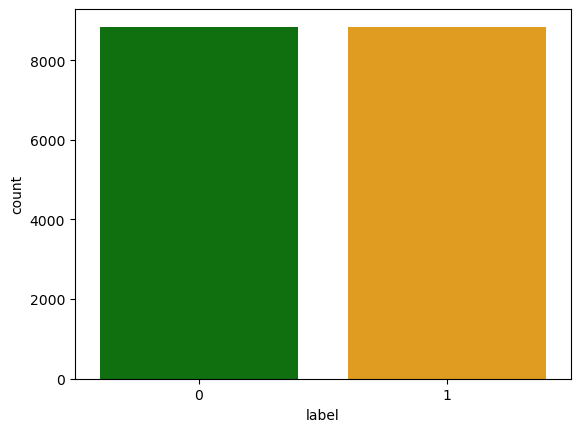

In [11]:
#Displaying the balanced data after over sampling
sns.countplot(x=y_train_ros, palette=['green','orange'])

In [12]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X_train_ros,y_train_ros, test_size=0.2, random_state=44, stratify=y_train_ros)

In [13]:
# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


In [14]:
# Padding sequences
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [16]:
# Define embedding dimensions
embedding_dim = 100

# Word Embedding Techniques

In [17]:
# Load GloVe embeddings
glove_file = 'glove.6B.100d.txt'
word2vec_glove_file = 'glove.6B.100d.word2vec.txt'

In [18]:

if not os.path.exists(glove_file):
    raise FileNotFoundError(f"{glove_file} not found. Please download it from https://nlp.stanford.edu/projects/glove/ and place it in the working directory.")


In [19]:
glove2word2vec(glove_file, word2vec_glove_file)
glove_model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

C:\Users\Sochima\AppData\Local\Temp\ipykernel_4624\2220563736.py:1: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_glove_file)


In [20]:
# Create GloVe embedding matrix
glove_embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in glove_model:
        glove_embedding_matrix[i] = glove_model[word]

In [21]:
# Train Word2Vec model
sentences = [tweet.split() for tweet in X_train]
word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)

In [22]:
# Create Word2Vec embedding matrix
word2vec_embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        word2vec_embedding_matrix[i] = word2vec_model.wv[word]

# Deep Learning Model

In [23]:
# Define models
def create_simple_nn(embedding_matrix):
    model = Sequential([
        Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
        Flatten(),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [24]:
def create_lstm_model(embedding_matrix):
    model = Sequential([
        Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
        LSTM(100, return_sequences=True),
        LSTM(100),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [25]:
def create_cnn_model(embedding_matrix):
    model = Sequential([
        Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(pool_size=4),
        Flatten(),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [26]:
# Create and train models for GloVe
models_glove = {
    'simple_nn': create_simple_nn(glove_embedding_matrix),
    'lstm': create_lstm_model(glove_embedding_matrix),
    'cnn': create_cnn_model(glove_embedding_matrix)
}


In [27]:
histories_glove = {}
for name, model in models_glove.items():
    print(f"Training {name} model with GloVe embeddings...")
    histories_glove[name] = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

Training simple_nn model with GloVe embeddings...
Epoch 1/10
442/442 [==============================] - 3s 6ms/step - loss: 0.6114 - accuracy: 0.6599 - val_loss: 0.5652 - val_accuracy: 0.7217
Epoch 2/10
442/442 [==============================] - 2s 6ms/step - loss: 0.4971 - accuracy: 0.7653 - val_loss: 0.5278 - val_accuracy: 0.7463
Epoch 3/10
442/442 [==============================] - 2s 6ms/step - loss: 0.4305 - accuracy: 0.8056 - val_loss: 0.5166 - val_accuracy: 0.7574
Epoch 4/10
442/442 [==============================] - 2s 6ms/step - loss: 0.3779 - accuracy: 0.8382 - val_loss: 0.5075 - val_accuracy: 0.7721
Epoch 5/10
442/442 [==============================] - 3s 6ms/step - loss: 0.3308 - accuracy: 0.8622 - val_loss: 0.4980 - val_accuracy: 0.7828
Epoch 6/10
442/442 [==============================] - 3s 6ms/step - loss: 0.2880 - accuracy: 0.8847 - val_loss: 0.5127 - val_accuracy: 0.7794
Epoch 7/10
442/442 [==============================] - 2s 6ms/step - loss: 0.2476 - accuracy: 0.902

In [28]:
# Create and train models for Word2Vec
models_word2vec = {
    'simple_nn': create_simple_nn(word2vec_embedding_matrix),
    'lstm': create_lstm_model(word2vec_embedding_matrix),
    'cnn': create_cnn_model(word2vec_embedding_matrix)
}


In [29]:
histories_word2vec = {}
for name, model in models_word2vec.items():
    print(f"Training {name} model with Word2Vec embeddings...")
    histories_word2vec[name] = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

Training simple_nn model with Word2Vec embeddings...
Epoch 1/10
442/442 [==============================] - 4s 8ms/step - loss: 0.6851 - accuracy: 0.5480 - val_loss: 0.6798 - val_accuracy: 0.5563
Epoch 2/10
442/442 [==============================] - 4s 8ms/step - loss: 0.6777 - accuracy: 0.5669 - val_loss: 0.6764 - val_accuracy: 0.5650
Epoch 3/10
442/442 [==============================] - 3s 7ms/step - loss: 0.6707 - accuracy: 0.5809 - val_loss: 0.6753 - val_accuracy: 0.5642
Epoch 4/10
442/442 [==============================] - 3s 7ms/step - loss: 0.6645 - accuracy: 0.5936 - val_loss: 0.6721 - val_accuracy: 0.5631
Epoch 5/10
442/442 [==============================] - 4s 8ms/step - loss: 0.6585 - accuracy: 0.5944 - val_loss: 0.6851 - val_accuracy: 0.5639
Epoch 6/10
442/442 [==============================] - 3s 7ms/step - loss: 0.6538 - accuracy: 0.6017 - val_loss: 0.6728 - val_accuracy: 0.5735
Epoch 7/10
442/442 [==============================] - 2s 5ms/step - loss: 0.6477 - accuracy: 0.

In [30]:
# Evaluate models
def evaluate_models(models, X_test_pad, y_test):
    for name, model in models.items():
        y_pred = (model.predict(X_test_pad) > 0.5).astype(int)
        print(f"{name} Model Classification Report:\n", classification_report(y_test, y_pred))

In [31]:
print("Evaluation with GloVe embeddings:")
evaluate_models(models_glove, X_test_pad, y_test)


Evaluation with GloVe embeddings:
111/111 [==============================] - 1s 4ms/step
simple_nn Model Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81      1768
           1       0.82      0.78      0.80      1768

    accuracy                           0.81      3536
   macro avg       0.81      0.81      0.81      3536
weighted avg       0.81      0.81      0.81      3536

111/111 [==============================] - 9s 71ms/step
lstm Model Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83      1768
           1       0.84      0.81      0.83      1768

    accuracy                           0.83      3536
   macro avg       0.83      0.83      0.83      3536
weighted avg       0.83      0.83      0.83      3536

111/111 [==============================] - 1s 8ms/step
cnn Model Classification Report:
               precision    recall  f1

In [32]:
print("Evaluation with Word2Vec embeddings:")
evaluate_models(models_word2vec, X_test_pad, y_test)

Evaluation with Word2Vec embeddings:
111/111 [==============================] - 0s 3ms/step
simple_nn Model Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.68      0.61      1768
           1       0.59      0.46      0.52      1768

    accuracy                           0.57      3536
   macro avg       0.57      0.57      0.56      3536
weighted avg       0.57      0.57      0.56      3536

111/111 [==============================] - 9s 72ms/step
lstm Model Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.77      0.68      1768
           1       0.68      0.49      0.57      1768

    accuracy                           0.63      3536
   macro avg       0.64      0.63      0.62      3536
weighted avg       0.64      0.63      0.62      3536

111/111 [==============================] - 1s 8ms/step
cnn Model Classification Report:
               precision    recall 